# Read in the data

In [3]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [13]:
#make matplotlib work in jupyter notebook
%matplotlib inline

Create a bar plot with the correlaltions between survey fields and sat_score

In [14]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


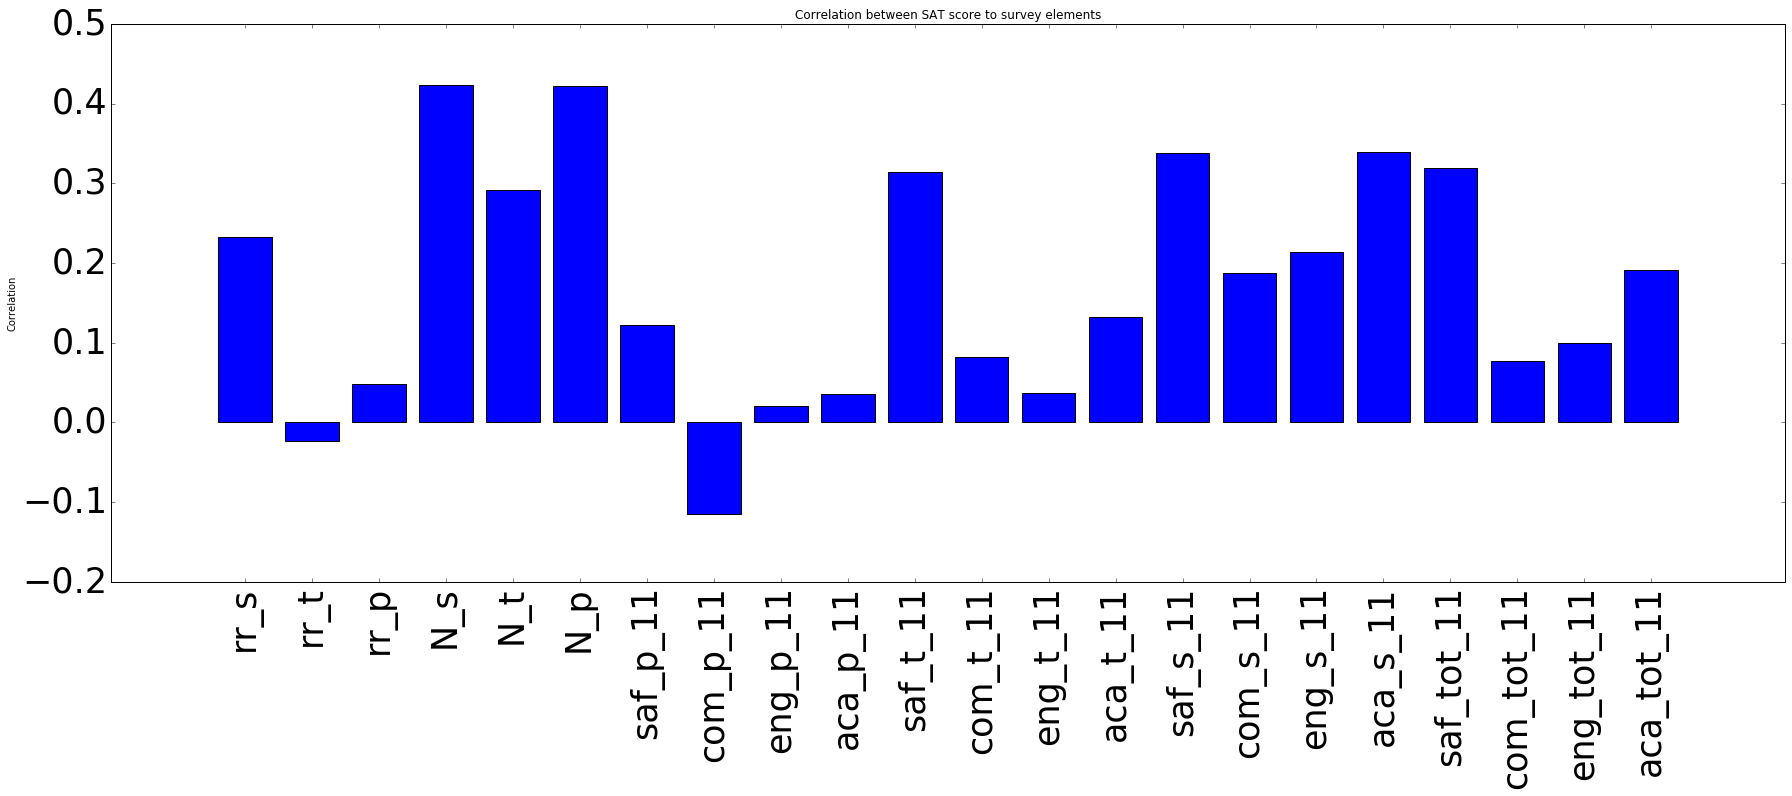

In [42]:
# preparing the y labels for the bar plot
import numpy as np
y_values = []
for i in survey_fields:
    y_values.append(correlations.loc[i]) 

plt.figure(figsize=(30, 10))    
y_pos = np.arange(len(y_values)) + 2
plt.bar(y_pos, y_values, align='center')

plt.xticks(y_pos, survey_fields)
plt.xticks(size = 35, rotation=90)
plt.yticks(size = 35)
plt.ylabel('Correlation')
plt.title('Correlation between SAT score to survey elements')

plt.show()

From this bar char of correlations, we can see that there are some columns that present a positive corelation with the SAT score:
N_s - Number of student respondents
N_p - Number of parent respondents
saf_t_ll - Safety and Respect score based on teacher responses
saf_s_ll - Safety and Respect score based on student responses
aca_s_ll - Academic expectations score based on student responses
saf_tot_ll - Safety and Respect total score

so there is a correlation between the feeling of safety and academic expectations and the SAT scores

In this section we will explore more the safety scores 
and see which schools have low safety score

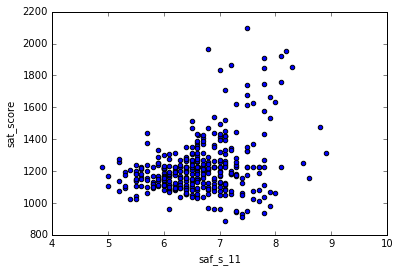

In [46]:
combined.plot.scatter(x="saf_s_11", y="sat_score");


it seems there is a positive correlation between the two - now lets map it to see where these scolls are located

In [51]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()


,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


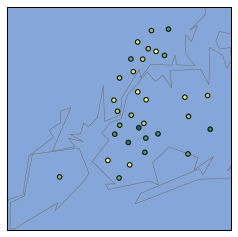

In [56]:
from mpl_toolkits.basemap import Basemap

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.scatter(longitudes,latitudes, s=20,zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

plt.show()

looks like there are dsitricts with very high safty scores (yellow dots) and districts that have very low scores (dark green dots). the upper side seems to have better saftey scores thn the lower side.

Now we will explroe race correlation with SAT scores

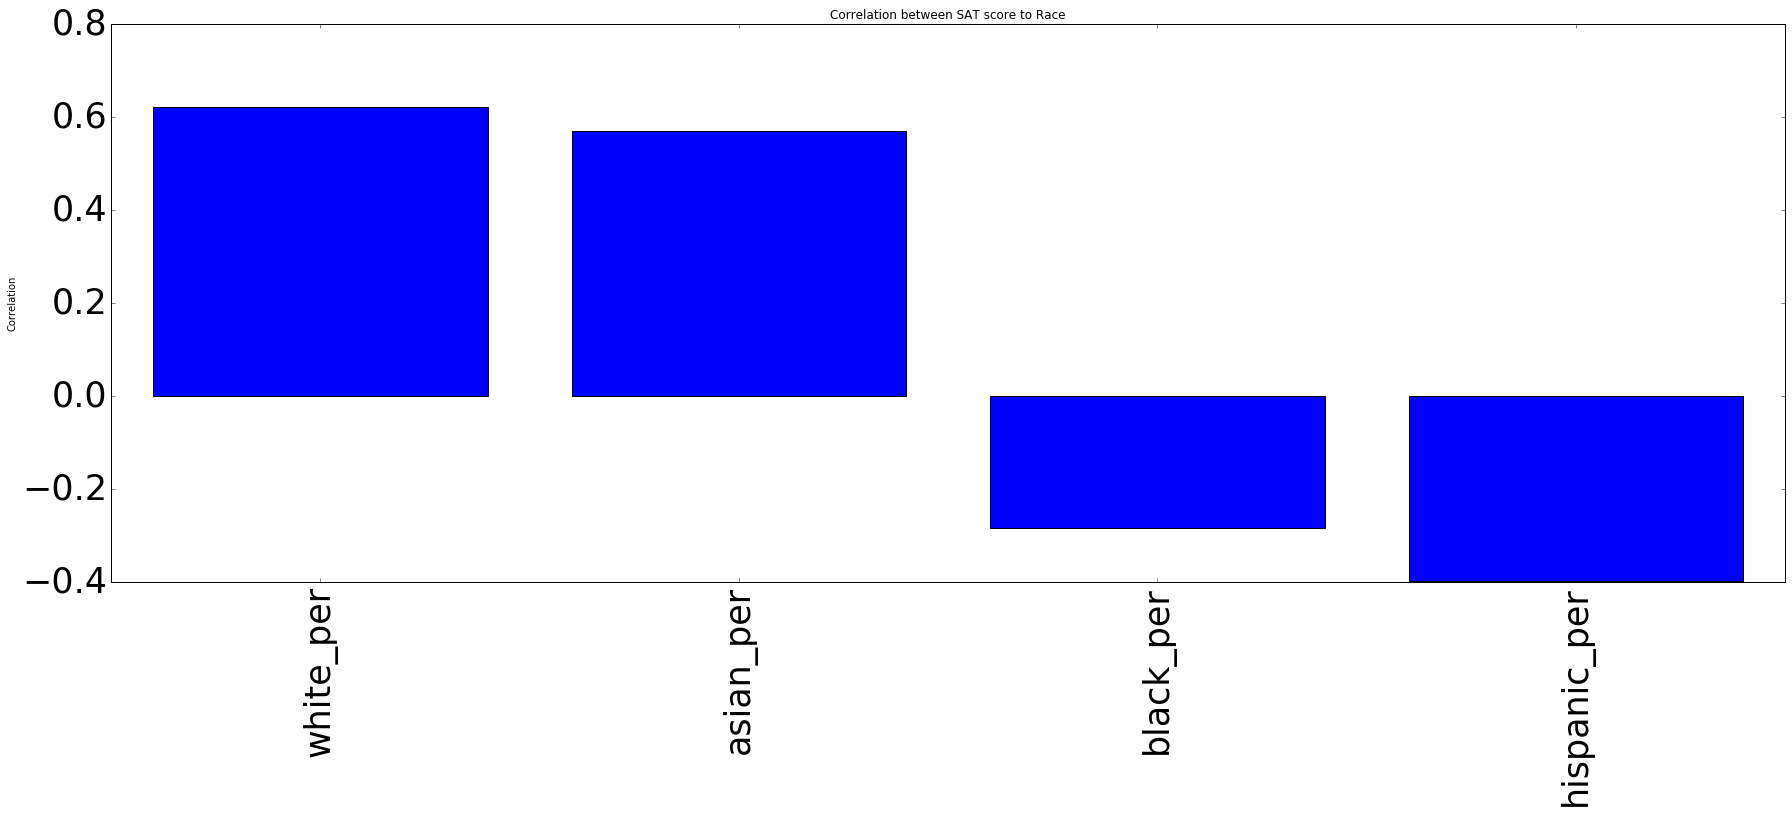

In [58]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

y_values = []
for i in race_cols:
    y_values.append(correlations.loc[i]) 

plt.figure(figsize=(30, 10))    
y_pos = np.arange(len(y_values)) + 2
plt.bar(y_pos, y_values, align='center')

plt.xticks(y_pos, race_cols)
plt.xticks(size = 35, rotation=90)
plt.yticks(size = 35)
plt.ylabel('Correlation')
plt.title('Correlation between SAT score to Race')

plt.show()


It looks like there is a positive correlation between a higher percentage of white or asians to higher SAT scores while there is a negative correlation between black or hispanic percentage to SAT sores. if we specifically loot at a scatter plot of hispanic percentage vs SAT scores we can see the negative correlation. when the percentges of hispanic population goes beyond30 it seems like the SAT scores drop dramatically.

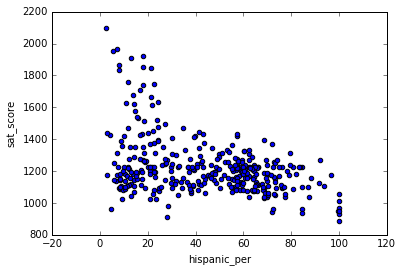

In [59]:
combined.plot.scatter(x="hispanic_per", y="sat_score");

In [62]:
hispanic_95 = combined[combined['hispanic_per'] > 95]
print(hispanic_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems these schools are primarly for immegrants and thus it could explaine the lower ST scores

In [65]:
hispanic_10 = combined[combined['hispanic_per'] < 10]
hispanic_10 = hispanic_10[hispanic_10['sat_score'] > 1800]
print(hispanic_10['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools test their students and only those who pass the tests can be accepted. they are also focused on science and technology so it will explain the higher SAT scores. since immigrants will havea hard time passing the addmissions test becauee English is not their first language it would explain why their percentage in these schools is low

Now we will explore the correlation between gender and SAT scores

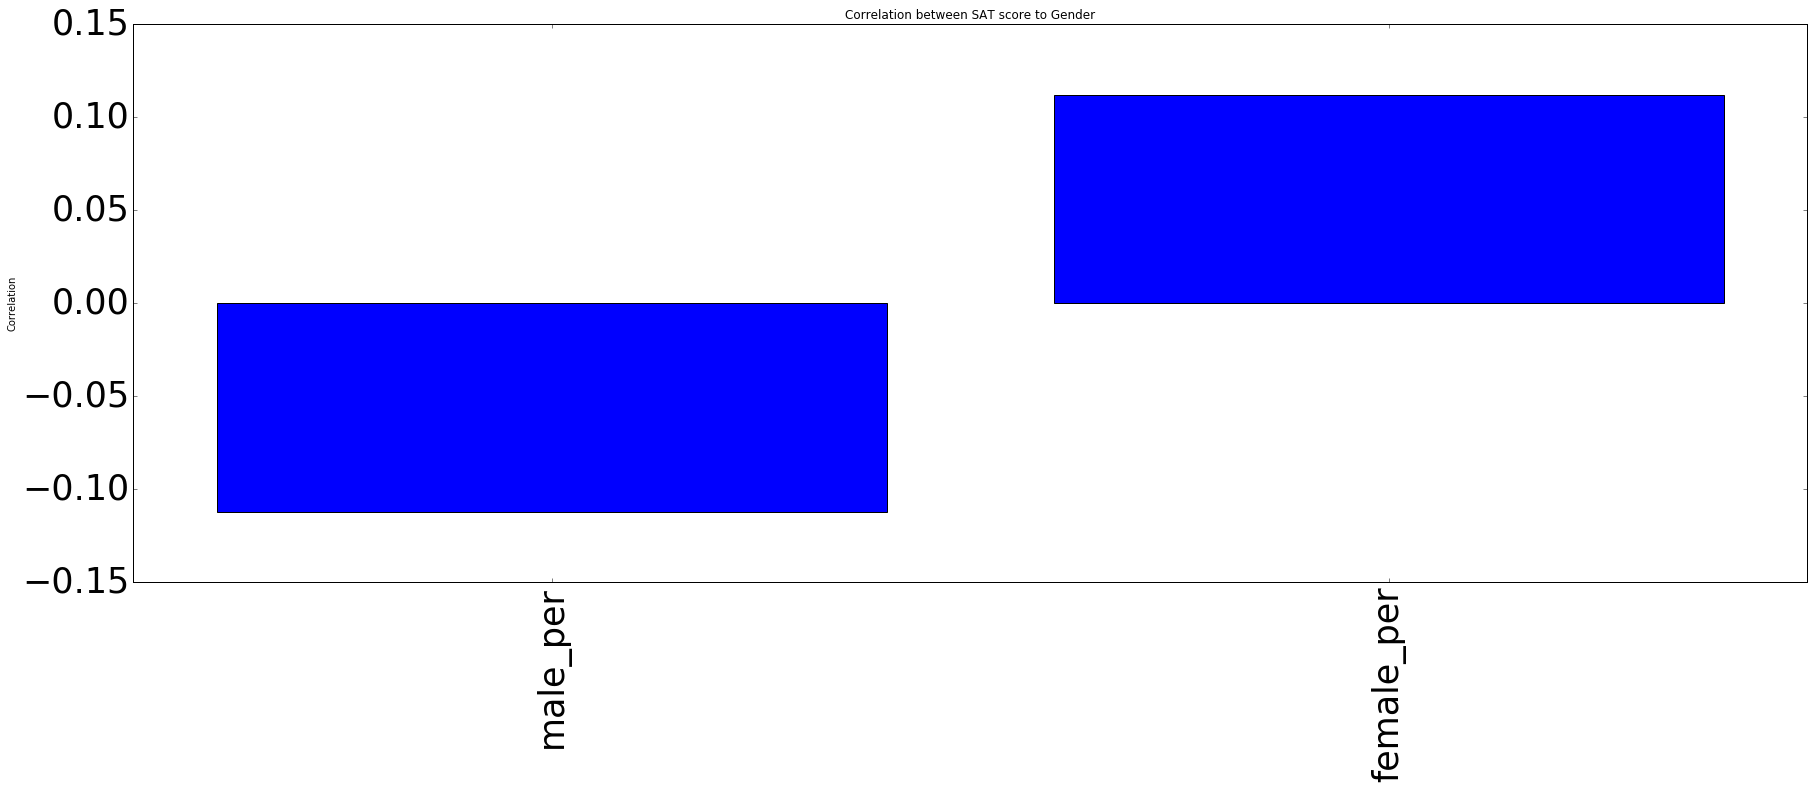

In [66]:
gender_cols = ['male_per', 'female_per']

y_values = []
for i in gender_cols:
    y_values.append(correlations.loc[i]) 

plt.figure(figsize=(30, 10))    
y_pos = np.arange(len(y_values)) + 2
plt.bar(y_pos, y_values, align='center')

plt.xticks(y_pos, gender_cols)
plt.xticks(size = 35, rotation=90)
plt.yticks(size = 35)
plt.ylabel('Correlation')
plt.title('Correlation between SAT score to Gender')

plt.show()

Well it doesn't seem to be a strong correlation however the interesting thing is that the greater male percentage is the lower SAT scores and the opposite for Female - the higher percentage of females the higher SAT scores. but again this is not a strong correlation. you can see it in this scatter plot below

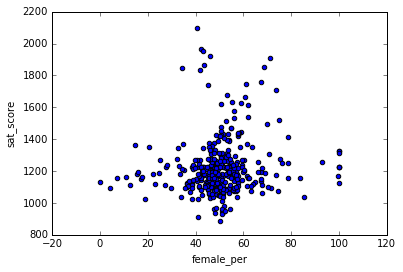

In [67]:
combined.plot.scatter(x="female_per", y="sat_score");

In [74]:
female_60 = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
print(female_60['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Seems these schools also have very selective tests for their applicants and very few are accepted so it will explain the higher SAT scores

Now we will look at the correlation between AP test takers to SAT scores

In [75]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

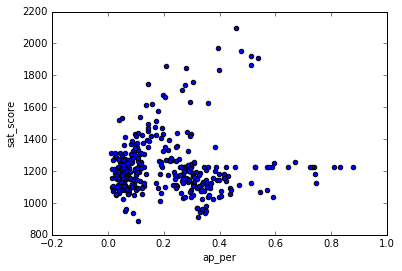

In [76]:
combined.plot.scatter(x="ap_per", y="sat_score");

looks like there is a positive correlation between the AP per and SAT scores but it is up to a point. from 60^ it seems the correlation is less relevant